## Mount drive to access data files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing library


In [ ]:
import json
import pandas as pd
import os
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split,RandomizedSearchCV, StratifiedKFold,GridSearchCV,learning_curve
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_curve,precision_recall_curve, roc_auc_score, balanced_accuracy_score, make_scorer,classification_report,cohen_kappa_score,confusion_matrix,auc,average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import FalsePositives, FalseNegatives
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, make_scorer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

## data paths

In [ ]:
train_path = '/content/drive/MyDrive/Structured_Data_Assignment/Structured_Data_Assignment/train.parquet'
test_path = '/content/drive/MyDrive/Structured_Data_Assignment/Structured_Data_Assignment/test.parquet'

## Load the data


### train data

In [ ]:
data= pd.read_parquet(train_path)

In [ ]:
data

,Patient-Uid,Date,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,PRIMARY_DIAGNOSIS
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,PRIMARY_DIAGNOSIS
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,SYMPTOM_TYPE_0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,DRUG_TYPE_0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,DRUG_TYPE_1
...,...,...,...
29080886,a0ee9f75-1c7c-11ec-94c7-16262ee38c7f,2018-07-06,DRUG_TYPE_6
29080897,a0ee1284-1c7c-11ec-a3d5-16262ee38c7f,2017-12-29,DRUG_TYPE_6
29080900,a0ee9b26-1c7c-11ec-8a40-16262ee38c7f,2018-10-18,DRUG_TYPE_10
29080903,a0ee1a92-1c7c-11ec-8341-16262ee38c7f,2015-09-18,DRUG_TYPE_6


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3220868 entries, 0 to 29080911
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Patient-Uid  object        
 1   Date         datetime64[ns]
 2   Incident     object        
dtypes: datetime64[ns](1), object(2)
memory usage: 98.3+ MB


In [ ]:
data.describe()

<ipython-input-24-2bb0b18689d4>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe()


,Patient-Uid,Date,Incident
count,3220868,3220868,3220868
unique,27033,1977,57
top,a0ddfd2c-1c7c-11ec-876d-16262ee38c7f,2019-05-21 00:00:00,DRUG_TYPE_6
freq,1645,3678,561934
first,NaN,2015-04-07 00:00:00,NaN
last,NaN,2020-09-03 00:00:00,NaN


## Preprocess the data

In [ ]:
positive_patients = data[data['Incident'] == 'TARGET DRUG']['Patient-Uid'].unique()
data['Eligible'] = np.where(data['Patient-Uid'].isin(positive_patients), 1, 0)
data['Date'] = pd.to_datetime(data['Date'])
data['DaysSinceLastEvent'] = (data.groupby('Patient-Uid')['Date'].diff() / np.timedelta64(1, 'D')).fillna(0)
label_encoder = LabelEncoder()
data['Incident'] = label_encoder.fit_transform(data['Incident'])
data

,Patient-Uid,Date,Incident,Eligible,DaysSinceLastEvent
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,19,0,0.0
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,19,0,0.0
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,20,0,0.0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,0,0,0.0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,1,0,0.0
...,...,...,...,...,...
29080886,a0ee9f75-1c7c-11ec-94c7-16262ee38c7f,2018-07-06,15,1,944.0
29080897,a0ee1284-1c7c-11ec-a3d5-16262ee38c7f,2017-12-29,15,1,-645.0
29080900,a0ee9b26-1c7c-11ec-8a40-16262ee38c7f,2018-10-18,2,1,502.0
29080903,a0ee1a92-1c7c-11ec-8341-16262ee38c7f,2015-09-18,15,1,-1016.0


## Analysis the data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3220868 entries, 0 to 29080911
Data columns (total 5 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Patient-Uid         object        
 1   Date                datetime64[ns]
 2   Incident            int64         
 3   Eligible            int64         
 4   DaysSinceLastEvent  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 147.4+ MB


### Analysis the train data in terms of values


In [ ]:
for column in data.columns:
  print(column,'\n''---------------------------------------\n',data[column].value_counts(),'\n\n')

Patient-Uid 
---------------------------------------
 a0ddfd2c-1c7c-11ec-876d-16262ee38c7f    1645
a0ea618f-1c7c-11ec-93fb-16262ee38c7f    1320
a0e553c4-1c7c-11ec-83f1-16262ee38c7f    1163
a0df4809-1c7c-11ec-be0b-16262ee38c7f    1099
a0ec2afe-1c7c-11ec-befd-16262ee38c7f    1075
                                        ... 
a0ecc127-1c7c-11ec-92b5-16262ee38c7f      31
a0eb794b-1c7c-11ec-92d7-16262ee38c7f      30
a0f02cd8-1c7c-11ec-96a0-16262ee38c7f      28
a0efac48-1c7c-11ec-9daa-16262ee38c7f      25
a0f0d0b5-1c7c-11ec-9901-16262ee38c7f      24
Name: Patient-Uid, Length: 27033, dtype: int64 


Date 
---------------------------------------
 2019-05-21    3678
2019-05-22    3387
2019-03-05    3198
2019-05-14    3169
2019-03-12    3034
              ... 
2018-02-28     312
2017-02-28     286
2020-02-29     285
2016-01-29     273
2016-02-29     259
Name: Date, Length: 1977, dtype: int64 


Incident 
---------------------------------------
 15    561934
1     484666
19    431902
0     300005


### Calculating the number of nan values


In [ ]:
data.isna().sum()

Patient-Uid           0
Date                  0
Incident              0
Eligible              0
DaysSinceLastEvent    0
dtype: int64

## Analysis the train data using charts

## histograms

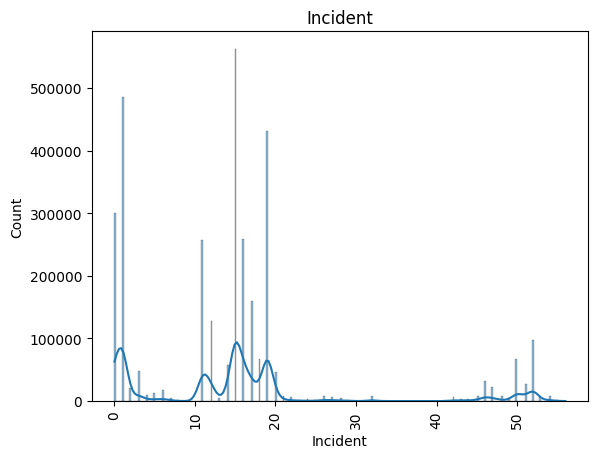

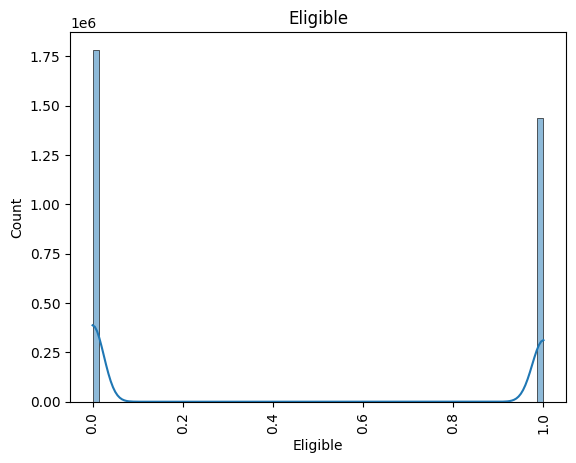

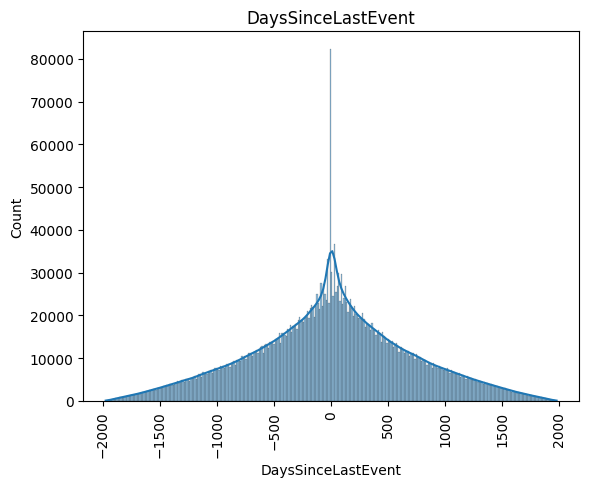

In [ ]:
for column in data.columns:
    if data[column].dtype in ['int64', 'float64','datetime64']:
        sns.histplot(data = data[column], kde=True, multiple='stack')
        plt.xticks(rotation=90)
        plt.title(column)
        plt.show()

### line chart of Eligible over time


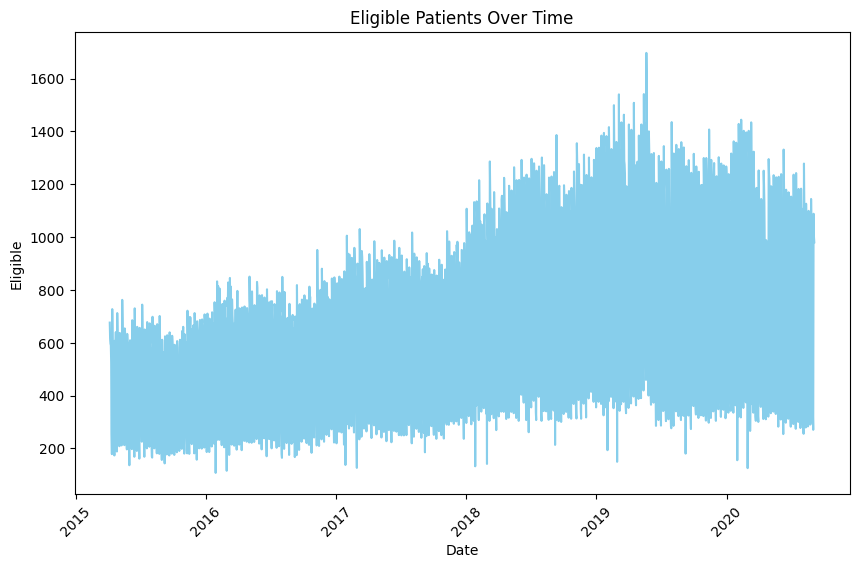

In [ ]:
# Group the data by Date and calculate the sum of Eligible
eligible_sum = data.groupby('Date')['Eligible'].sum()
plt.figure(figsize=(10, 6))
plt.plot(eligible_sum.index, eligible_sum.values, color='skyblue')
plt.xlabel('Date')
plt.ylabel('Eligible')
plt.title('Eligible Patients Over Time')
plt.xticks(rotation=45)
plt.show()

### scatter chart of DaysSinceLastEvent vs. Incident


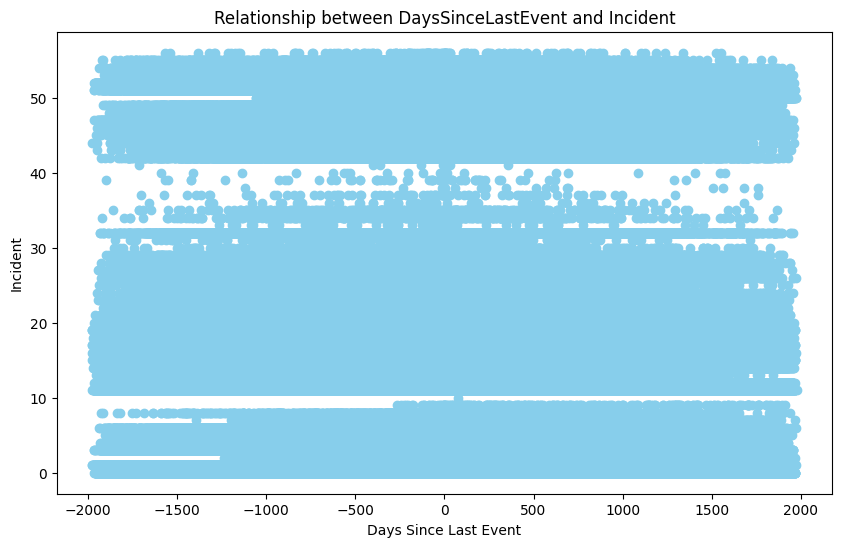

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(data['DaysSinceLastEvent'], data['Incident'], color='skyblue')
plt.xlabel('Days Since Last Event')
plt.ylabel('Incident')
plt.title('Relationship between DaysSinceLastEvent and Incident')
plt.show()

### 
box plot of DaysSinceLastEvent grouped by Incident

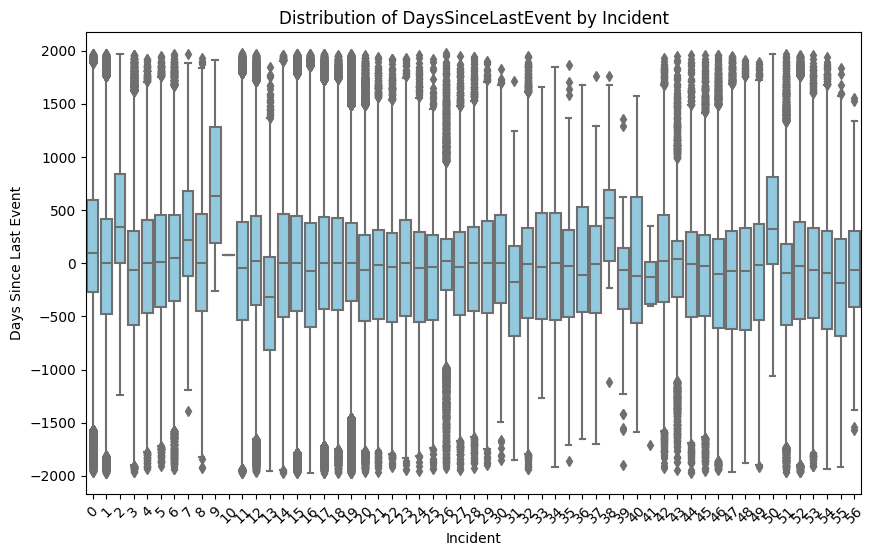

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Incident', y='DaysSinceLastEvent', data=data, color='skyblue')
plt.xlabel('Incident')
plt.ylabel('Days Since Last Event')
plt.title('Distribution of DaysSinceLastEvent by Incident')
plt.xticks(rotation=45)
plt.show()

### Violin plot of DaysSinceLastEvent grouped by Incident


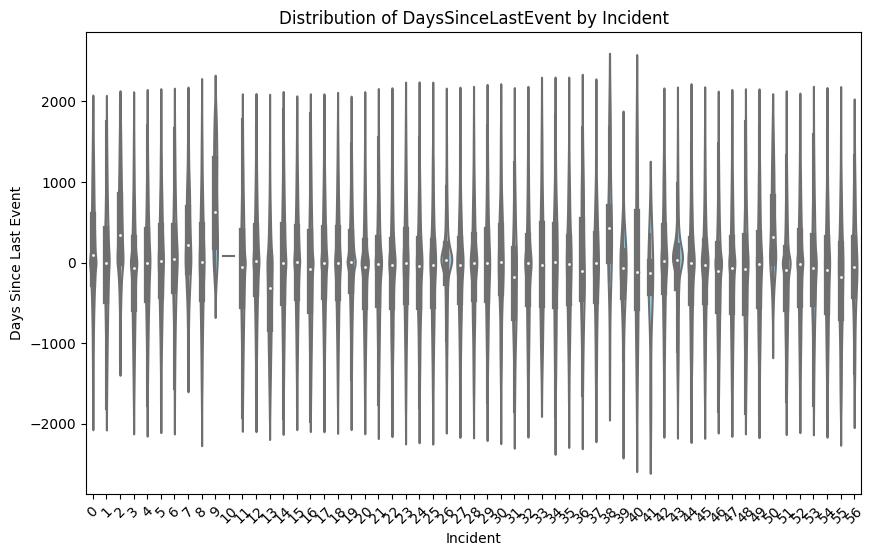

In [ ]:
plt.figure(figsize=(10,6))
sns.violinplot(x='Incident', y='DaysSinceLastEvent', data=data, color='skyblue')
plt.xlabel('Incident')
plt.ylabel('Days Since Last Event')
plt.title('Distribution of DaysSinceLastEvent by Incident')
plt.xticks(rotation=45)
plt.show()

### Pair plot of  features


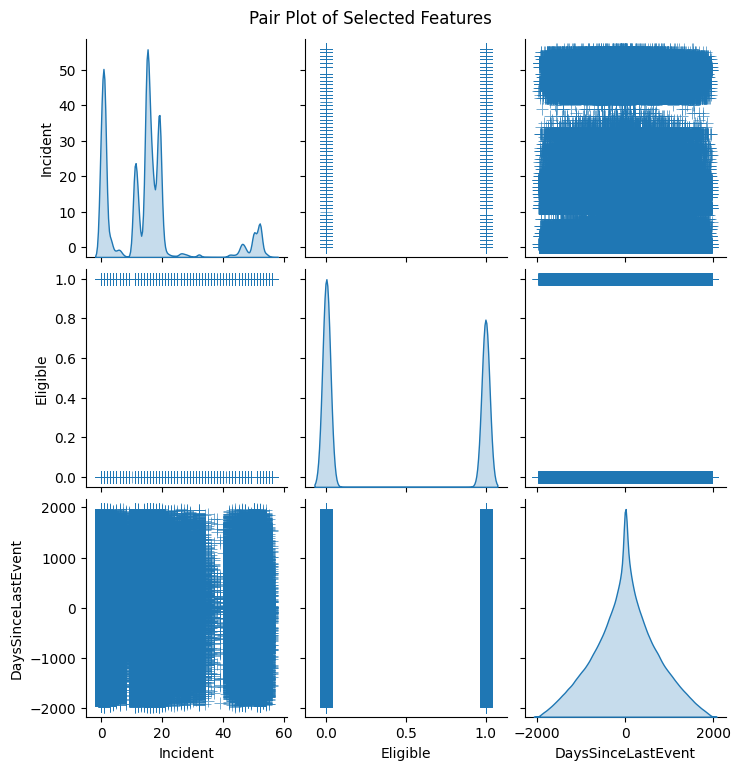

In [ ]:
selected_features = ['Incident', 'Eligible', 'DaysSinceLastEvent']
sns.pairplot(data[selected_features], diag_kind='kde', plot_kws={'alpha': 0.6, 's': 80}, markers='+')
plt.suptitle('Pair Plot of Selected Features', y=1.02)
plt.show()

### Compute the correlation matrix

<ipython-input-28-7f4e8160b410>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


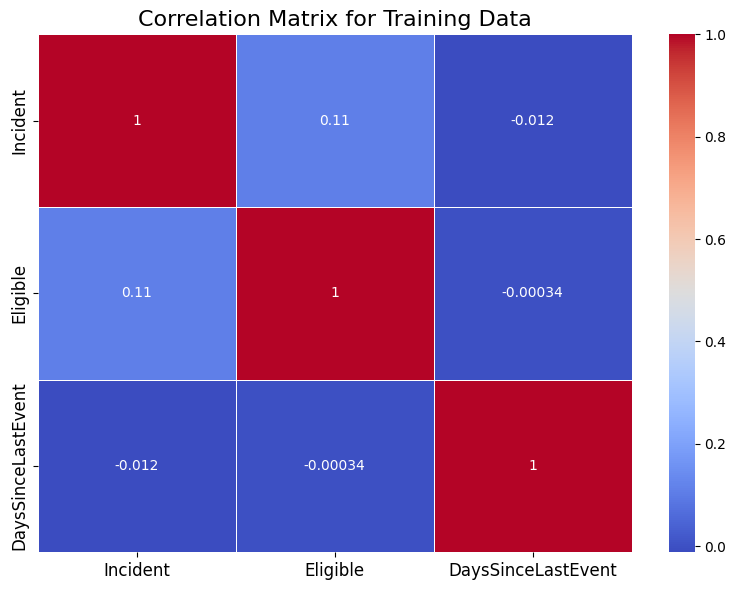

In [ ]:
corr_matrix = data.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, linewidths=0.5)
plt.title("Correlation Matrix for Training Data", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

##  Prepare the input sequences and labels

In [ ]:
sequence_length = 30  # Number of past days to consider for predictions
features = ['Incident', 'DaysSinceLastEvent']
X = []
y = []

for patient, group in data.groupby('Patient-Uid'):
    group = group.sort_values('Date')
    if len(group) >= sequence_length:
        patient_sequence = group[features].values[-sequence_length:]
        X.append(patient_sequence)
        y.append(group['Eligible'].values[-1])

X = np.array(X)
y = np.array(y)

##  Split the data into training and validation sets


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape,y_train.shape

((21624, 30, 2), (21624,))

In [ ]:
X_val.shape,y_val.shape

((5406, 30, 2), (5406,))

## Define model

In [ ]:
#create the LSTM model
def create_model(units=32, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units, input_shape=(sequence_length, len(features))))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

#KerasClassifier wrapper
model_wrapper = KerasClassifier(build_fn=create_model, epochs=20, batch_size=100, verbose=1)

# hyperparameters grid
param_grid = {
    'units': [32, 64, 128],  # Number of units in the LSTM layer
    'dropout_rate': [0.2, 0.3, 0.4],  # Dropout rate
}

#F1 score as the scoring metric
scorer = make_scorer(f1_score)

# Perform grid search with F1 score as the evaluation metric
grid_search = GridSearchCV(estimator=model_wrapper, param_grid=param_grid, cv=5, scoring=scorer)
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
model = grid_search.best_estimator_

<ipython-input-33-9905ea01973c>:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_wrapper = KerasClassifier(build_fn=create_model, epochs=20, batch_size=100, verbose=1)


Epoch 1/20
173/173 [==============================] - 5s 15ms/step - loss: 0.6121 - accuracy: 0.6718
Epoch 2/20
173/173 [==============================] - 3s 15ms/step - loss: 0.4971 - accuracy: 0.7713
Epoch 3/20
173/173 [==============================] - 3s 15ms/step - loss: 0.4619 - accuracy: 0.7952
Epoch 4/20
173/173 [==============================] - 3s 20ms/step - loss: 0.4510 - accuracy: 0.8016
Epoch 5/20
173/173 [==============================] - 3s 20ms/step - loss: 0.4433 - accuracy: 0.8064
Epoch 6/20
173/173 [==============================] - 3s 15ms/step - loss: 0.4389 - accuracy: 0.8091
Epoch 7/20
173/173 [==============================] - 2s 14ms/step - loss: 0.4413 - accuracy: 0.8077
Epoch 8/20
173/173 [==============================] - 2s 14ms/step - loss: 0.4488 - accuracy: 0.8019
Epoch 9/20
173/173 [==============================] - 4s 21ms/step - loss: 0.4352 - accuracy: 0.8080
Epoch 10/20
173/173 [==============================] - 3s 19ms/step - loss: 0.4260 - accura

## best model

In [ ]:
model

## Fit the best model on the training data

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val))

Epoch 1/20
217/217 [==============================] - 21s 80ms/step - loss: 0.5185 - accuracy: 0.7472 - val_loss: 0.4270 - val_accuracy: 0.8122
Epoch 2/20
217/217 [==============================] - 16s 75ms/step - loss: 0.4308 - accuracy: 0.8104 - val_loss: 0.4092 - val_accuracy: 0.8121
Epoch 3/20
217/217 [==============================] - 16s 75ms/step - loss: 0.4224 - accuracy: 0.8157 - val_loss: 0.3980 - val_accuracy: 0.8256
Epoch 4/20
217/217 [==============================] - 16s 74ms/step - loss: 0.4155 - accuracy: 0.8198 - val_loss: 0.3965 - val_accuracy: 0.8259
Epoch 5/20
217/217 [==============================] - 19s 86ms/step - loss: 0.4108 - accuracy: 0.8211 - val_loss: 0.3965 - val_accuracy: 0.8239
Epoch 6/20
217/217 [==============================] - 19s 87ms/step - loss: 0.4110 - accuracy: 0.8218 - val_loss: 0.3959 - val_accuracy: 0.8319
Epoch 7/20
217/217 [==============================] - 16s 75ms/step - loss: 0.4069 - accuracy: 0.8250 - val_loss: 0.3944 - val_accuracy:

## Analysis best hyperparameters and best scores

In [ ]:
print("Best hyperparameters: \n", grid_search.best_params_,'\n')
print("Best score: ", grid_search.best_score_,'\n\n')

Best hyperparameters: 
 {'dropout_rate': 0.3, 'units': 128} 

Best score:  0.7520681761806567 




## Make predictions on the X_val

In [ ]:
val_predictions = model.predict(X_val)
val_predictions = np.round(val_predictions).flatten()

169/169 [==============================] - 4s 24ms/step


##  Various analysis on prediction of the X_val data


## Calculate the confusion matrix

<Axes: >

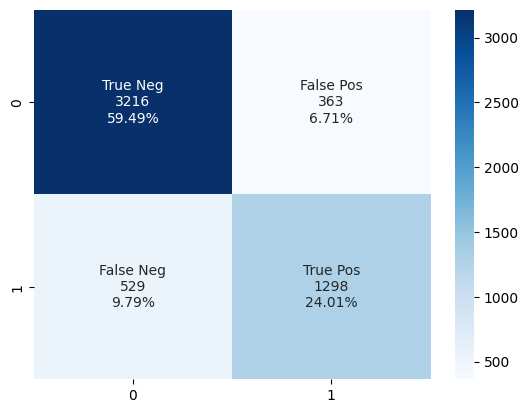

In [ ]:
c = confusion_matrix(y_val, val_predictions)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in c.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in c.flatten()/np.sum(c)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(c, annot=labels, fmt='', cmap='Blues')

## Classification report

In [ ]:
print(classification_report(y_val, val_predictions))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3579
           1       0.78      0.71      0.74      1827

    accuracy                           0.83      5406
   macro avg       0.82      0.80      0.81      5406
weighted avg       0.83      0.83      0.83      5406



##  Learning Curve

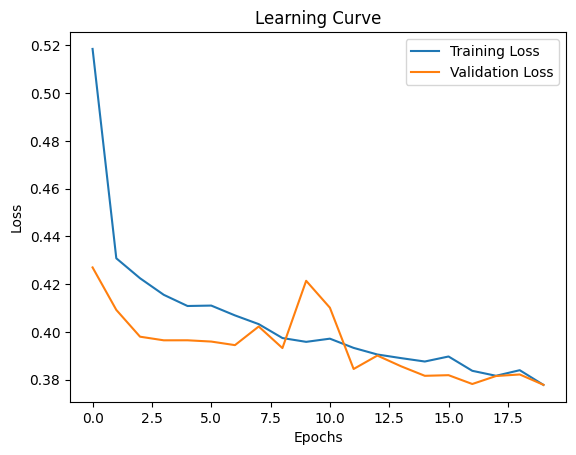

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Print the various scores and metrics

In [ ]:
# Calculate precision, recall, accuracy, and F1 score 
precision = precision_score(y_val, val_predictions)
recall = recall_score(y_val, val_predictions)
accuracy = accuracy_score(y_val, val_predictions)
f1 = f1_score(y_val, val_predictions)

# Calculate the ROC curve and ROC AUC score 
y_pred_prob = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = roc_auc_score(y_val, y_pred_prob)
# Calculate the Kappa score 
kappa = cohen_kappa_score(y_val, val_predictions)
# Calculate the average precision score 
avg_precision = average_precision_score(y_val, y_pred_prob)
balanced_accuracy = balanced_accuracy_score(y_val, val_predictions)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 score:", f1)
print("ROC AUC Score:", roc_auc)
print("Balanced accuracy score:", balanced_accuracy)
print("Average Precision Score:", avg_precision)
print("Kappa score:", kappa)

169/169 [==============================] - 2s 12ms/step
Precision: 0.7814569536423841
Recall: 0.7104542966611932
Accuracy: 0.8349981502034776
F1 score: 0.7442660550458715
ROC AUC Score: 0.897626074866876
Balanced accuracy score: 0.8045146588083837
Average Precision Score: 0.8224224122400835
Kappa score: 0.6228814732403658


## Precision-Recall Curve 

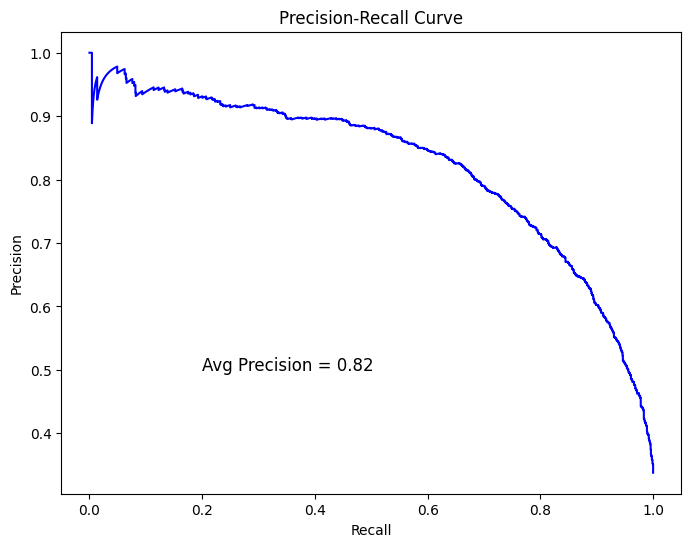

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_val,y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Add the average precision score to the plot
avg_precision = average_precision_score(y_val, y_pred_prob)
plt.text(0.2, 0.5, 'Avg Precision = {:.2f}'.format(avg_precision), fontsize=12)

plt.show()

## ROC curve

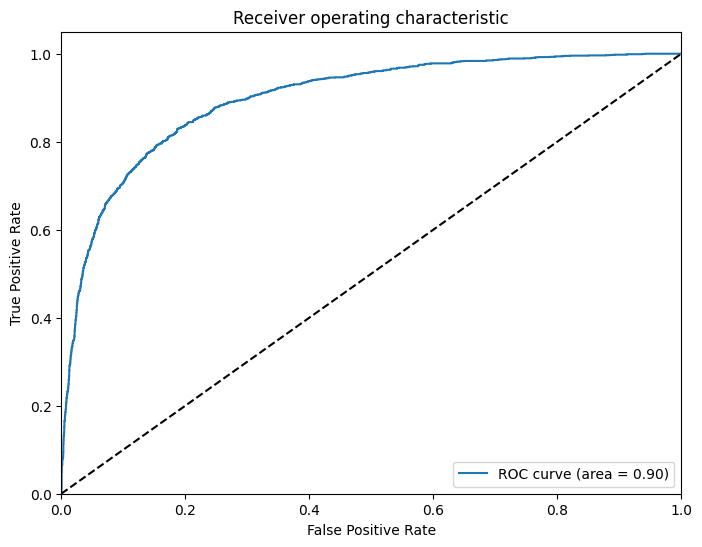

In [ ]:
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

##  Predict for test data

### preprocessing test data

In [ ]:
test_data = pd.read_parquet(test_path)
test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data['DaysSinceLastEvent'] = (test_data.groupby('Patient-Uid')['Date'].diff() / np.timedelta64(1, 'D')).fillna(0)
test_data['Incident'] = label_encoder.transform(test_data['Incident'])

test_X = []

for patient, group in test_data.groupby('Patient-Uid'):
    group = group.sort_values('Date')

    if len(group) >= sequence_length:
        patient_sequence = group[features].values[-sequence_length:]
        test_X.append(patient_sequence)

test_X = np.array(test_X)

### Make predictions on the test data


In [ ]:
test_predictions = model.predict(test_X)
test_predictions = np.round(test_predictions).flatten()

353/353 [==============================] - 6s 17ms/step


## make final_submission csv file

In [ ]:
# Repeat patient UIDs based on the number of predictions
patient_uids = np.repeat(test_data['Patient-Uid'].unique(), sequence_length)[:len(test_predictions)]
# make final_submission csv file
submission_df = pd.DataFrame({'Patient-Uid': patient_uids, 'Prediction': test_predictions})
submission_df.to_csv('final_submission.csv', index=False)